## Install and import required libraries

The pip install command below installs the `LiteRT` library so that the model, stored in a `.tflite` file, may be integrated into the code environment.

Then, the import statements integrate that library as well as `TensorFlow`, `opencv`, and `matplotlib` for data manipulation and visualization.

In [2]:
%pip install ai-edge-litert
%pip install opencv-python
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ai-edge-litert (from versions: none)
ERROR: No matching distribution found for ai-edge-litert


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gradio as gr

c:\Users\NB-DPC\Downloads\misc\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Conditional Import: Choose the appropriate TFLite interpreter
try:
    # Import TFLite interpreter from ai_edge_litert package if available
    from ai_edge_litert.interpreter import Interpreter
    print("Using ai_edge_litert interpreter.")
except ImportError:
    # Fallback: Use the TFLite interpreter from the full TensorFlow package
    import tensorflow as tf
    Interpreter = tf.lite.Interpreter
    print("Fallback to TensorFlow TFLite interpreter.")

Fallback to TensorFlow TFLite interpreter.


In [6]:
# Initialize the TFLite interpreter for MoveNet
model_path = './thunder_v4.tflite'
movenet_interpreter = Interpreter(model_path=model_path)
movenet_interpreter.allocate_tensors()
print("MOVENET TFLite interpreter initialized and tensors allocated.")

MOVENET TFLite interpreter initialized and tensors allocated.


In [7]:
# Initialize the TFLite interpreter for the "both hands" pose classifier
model_path = './best_both_ACTUALTRAIN.tflite'
both_interpreter = Interpreter(model_path=model_path)
both_interpreter.allocate_tensors()
print("BOTH TFLite interpreter initialized and tensors allocated.")

BOTH TFLite interpreter initialized and tensors allocated.


In [8]:
# Initialize the TFLite interpreter for the "both hands + one hand (direction-agnostic)" pose classifier
model_path = './best_agnostic_ACTUALTRAIN.tflite'
agnostic_interpreter = Interpreter(model_path=model_path)
agnostic_interpreter.allocate_tensors()
print("AGNOSTIC TFLite interpreter initialized and tensors allocated.")

AGNOSTIC TFLite interpreter initialized and tensors allocated.


In [9]:
# Initialize the TFLite interpreter for the "both hands + one hand (direction-cognizant)" pose classifier
model_path = './best_cognizant_ACTUALTRAIN.tflite'
cognizant_interpreter = Interpreter(model_path=model_path)
cognizant_interpreter.allocate_tensors()
print("COGNIZANT TFLite interpreter initialized and tensors allocated.")

COGNIZANT TFLite interpreter initialized and tensors allocated.


In [10]:
# Define constants for configuration
RESIZE_TARGET = 256
CONFIDENCE_THRESHOLD = 0.5
RESIZED_KEYPOINT_RADIUS = 2
RESIZED_LINE_THICKNESS = 1
RESIZED_BOX_THICKNESS = 1
ORIGINAL_KEYPOINT_RADIUS = 25
ORIGINAL_LINE_THICKNESS = 10
ORIGINAL_BOX_THICKNESS = 10

In [11]:
# Define the mapping of indices to body parts
body_parts = [
    "nose", "left eye", "right eye", "left ear", "right ear",
    "left shoulder", "right shoulder", "left elbow", "right elbow",
    "left wrist", "right wrist", "left hip", "right hip",
    "left knee", "right knee", "left ankle", "right ankle"
]

# Define the pairs of keypoints that form the skeleton
KEYPOINT_CONNECTIONS = [
    (0, 1), (0, 2), (1, 3), (2, 4),    # Head
    (0, 5), (0, 6),                    # Shoulders
    (5, 7), (7, 9),                    # Left Arm
    (6, 8), (8, 10),                   # Right Arm
    (5, 6), (5, 11), (6, 12),          # Torso
    (11, 12),                          # Hips
    (11, 13), (13, 15),                # Left Leg
    (12, 14), (14, 16)                 # Right Leg
]

In [12]:
# Define class names for each pose classification model
class_names_both = ["arms_crossed", "down", "head_both", "hips_both", "out_both", "up_both"]
class_names_agnostic = [
    "arms_crossed", "down", "head_both", "head_one", "hips_both", "hips_one",
    "out_both", "out_one", "up_both", "up_one"
]
class_names_cognizant = [
    "arms_crossed", "down", "head_both", "head_left", "head_right", "hips_both",
    "hips_left", "hips_right", "out_both", "out_left", "out_right", "up_both",
    "up_left", "up_right"
]

In [13]:
def load_and_resize_image(image_path, target_size=RESIZE_TARGET):
    """
    Load an image from the given path and resize it to the target size with padding.

    Supports multiple image formats (e.g., JPG, PNG, BMP, GIF).

    Returns:
    - original_image: The original image tensor.
    - resized_image: The resized image tensor ready for inference.
    """
    # Read the image file
    original_image = tf.io.read_file(image_path)

    # Decode the image (automatically detects format)
    original_image = tf.image.decode_image(original_image, channels=3, expand_animations=False)

    # Resize the image with padding
    resized_image = tf.image.resize_with_pad(original_image, target_size, target_size)

    # Add batch dimension for inference compatibility
    return tf.expand_dims(original_image, axis=0), tf.expand_dims(resized_image, axis=0)

In [14]:
def scale_keypoints(keypoints, scale, pad_x, pad_y):
    """
    Scale normalized keypoints back to the original image dimensions.

    Parameters:
    - keypoints: Normalized keypoints.
    - scale: Scale factor.
    - pad_x, pad_y: Padding applied during resizing.

    Returns:
    - keypoints_pixel: Keypoints in pixel coordinates.
    """
    return np.array([
        ((kp[0] * RESIZE_TARGET - pad_y) / scale,
         (kp[1] * RESIZE_TARGET - pad_x) / scale)
        for kp in keypoints
    ]).astype(np.int32)

In [15]:
def display_original_image(image_tensor):
    plt.figure()
    image_for_display = tf.squeeze(image_tensor, axis=0)
    plt.imshow(image_for_display.numpy())
    plt.title('Original Image')
    plt.show()

In [16]:
def display_resized_image(image_tensor):
    resized_image_for_display = tf.squeeze(image_tensor, axis=0) / 255.0  # Normalize to 0-1 for display
    plt.figure()
    plt.imshow(resized_image_for_display.numpy())
    plt.title('Resized Image')
    plt.show()

In [17]:
def run_movenet(image_tensor):
    """
    Run inference using MoveNet and return the output tensor containing keypoints and confidence scores.

    Parameters:
    - image_tensor: Resized image tensor.

    Returns:
    - output_tensor: Array of shape (1, 1, 17, 3) containing y, x coordinates and confidence scores.
    """
    movenet_interpreter.set_tensor(movenet_interpreter.get_input_details()[0]['index'], tf.cast(image_tensor, tf.uint8).numpy())
    movenet_interpreter.invoke()
    return movenet_interpreter.get_tensor(movenet_interpreter.get_output_details()[0]['index'])

In [18]:
# Generic function to handle pose classification
def run_pose_classification(interpreter, class_names, input_data):
    """
    Runs pose classification using the provided interpreter and class names.
    """
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Flatten and prepare input data to match the model's requirements
    input_data = input_data.reshape(-1)  # Flatten to shape (51,)
    input_data = np.expand_dims(input_data, axis=0).astype(np.float32)  # Add batch dimension

    # Set the input tensor for the interpreter
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get classification output
    classification_output = interpreter.get_tensor(output_details[0]['index'])

    # Determine the predicted class
    predicted_class = np.argmax(classification_output)
    predicted_label = class_names[predicted_class]

    return {
        "classification_output": classification_output.tolist(),
        "predicted_class_index": int(predicted_class),
        "predicted_label": predicted_label
    }

In [19]:
# Run function for each model
def run_both_model(input_data):
    return run_pose_classification(both_interpreter, class_names_both, input_data)

In [20]:
def run_agnostic_model(input_data):
    return run_pose_classification(agnostic_interpreter, class_names_agnostic, input_data)

In [21]:

def run_cognizant_model(input_data):
    return run_pose_classification(cognizant_interpreter, class_names_cognizant, input_data)

In [22]:
def visualize_keypoints(image, keypoints, confidence_scores, confidence_threshold=CONFIDENCE_THRESHOLD,
                        overlay_skeleton=True, overlay_bbox=True, is_resized=True):
    """
    Generalized visualization function for keypoints, skeleton, and bounding box.

    Parameters:
    - image: Image array for visualization.
    - keypoints: Array of keypoints in pixel coordinates.
    - confidence_scores: Array of confidence scores for each keypoint.
    - confidence_threshold: Minimum confidence score to display a keypoint.
    - overlay_skeleton: Whether to overlay the skeleton.
    - overlay_bbox: Whether to overlay the bounding box.
    - is_resized: Whether the image is resized or original.

    Returns:
    - None (displays the overlayed image).
    """
    # Select visualization parameters based on the image type
    keypoint_radius = RESIZED_KEYPOINT_RADIUS if is_resized else ORIGINAL_KEYPOINT_RADIUS
    line_thickness = RESIZED_LINE_THICKNESS if is_resized else ORIGINAL_LINE_THICKNESS
    box_thickness = RESIZED_BOX_THICKNESS if is_resized else ORIGINAL_BOX_THICKNESS

    # Convert image to NumPy
    image_np = image.numpy().squeeze().astype(np.uint8)
    overlay_image = image_np.copy()

    # List to store valid keypoints
    valid_keypoints = []
    for i, (y, x) in enumerate(keypoints):
        if confidence_scores[i] >= confidence_threshold:
            valid_keypoints.append((int(x), int(y)))
            cv2.circle(overlay_image, (int(x), int(y)), keypoint_radius, (0, 255, 0), -1)
        else:
            valid_keypoints.append(None)

    # Draw skeleton
    if overlay_skeleton:
        for part_a, part_b in KEYPOINT_CONNECTIONS:
            if valid_keypoints[part_a] and valid_keypoints[part_b]:
                cv2.line(overlay_image, valid_keypoints[part_a], valid_keypoints[part_b], (255, 0, 0), line_thickness)

    # Draw bounding box
    if overlay_bbox:
        valid_keypoints_filtered = [kp for kp in valid_keypoints if kp]
        if valid_keypoints_filtered:
            x_coords = [x for x, y in valid_keypoints_filtered]
            y_coords = [y for x, y in valid_keypoints_filtered]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            cv2.rectangle(overlay_image, (x_min, y_min), (x_max, y_max), (0, 0, 255), box_thickness)

    # Display the overlayed image
    plt.imshow(overlay_image)
    plt.title("Keypoints Visualization")
    plt.show()

In [23]:
def visualize_keypoints_on_original_image(original_image, keypoints, confidence_scores):
    """
    Specializes visualization for original image dimensions.
    """
    original_height, original_width = tf.squeeze(original_image, axis=0).shape[:2]
    scale = min(RESIZE_TARGET / original_width, RESIZE_TARGET / original_height)
    pad_x = (RESIZE_TARGET - original_width * scale) / 2
    pad_y = (RESIZE_TARGET - original_height * scale) / 2

    keypoints_pixel = scale_keypoints(keypoints, scale, pad_x, pad_y)
    visualize_keypoints(original_image, keypoints_pixel, confidence_scores, is_resized=False)

In [24]:
# Specify the test image path
test_image_path = './test_image.jpg'

In [25]:
# Load and resize the image
original_image, resized_image = load_and_resize_image(test_image_path)

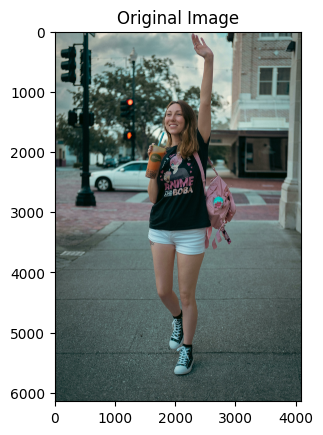

In [26]:
# Display the original image
display_original_image(original_image)

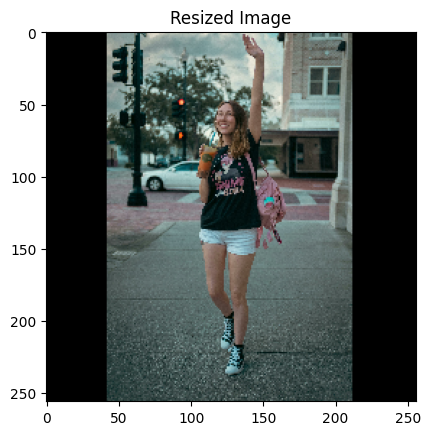

In [27]:
# Display the resized image
display_resized_image(resized_image)

In [28]:
# Run MoveNet inference and extract keypoints and confidence scores
output_tensor = run_movenet(resized_image)
keypoints = output_tensor[0, 0, :, :2]
confidence_scores = output_tensor[0, 0, :, 2]
classification_output = run_cognizant_model(output_tensor)
print(classification_output)

{'classification_output': [[1.4320980856806324e-14, 0.0, 4.543484166674716e-08, 0.0004785257624462247, 1.098060839761241e-37, 1.6354684199153442e-16, 1.178349274709098e-13, 0.0, 3.407422117357971e-14, 1.0626259694390683e-07, 1.3228132843714887e-36, 3.704365667545062e-07, 0.999521017074585, 3.410379736515449e-22]], 'predicted_class_index': 12, 'predicted_label': 'up_left'}


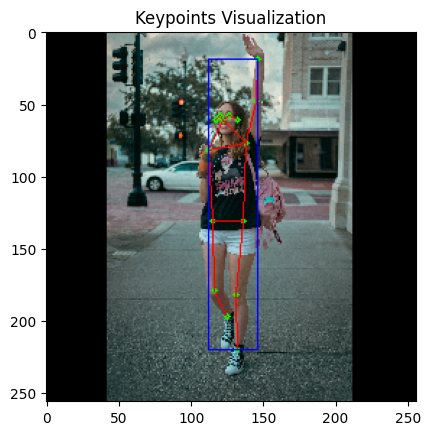

In [29]:
# Visualize keypoints on the resized image
visualize_keypoints(resized_image, (keypoints * RESIZE_TARGET).astype(np.int32), confidence_scores)

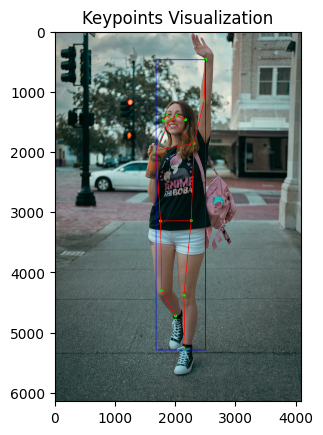

In [30]:
# Visualize keypoints on the original image
visualize_keypoints_on_original_image(original_image, keypoints, confidence_scores)

In [84]:
def switch_mode(mode):
    return (
        gr.update(visible=mode == "Image Upload"),
        gr.update(visible=mode == "Webcam Stream"),
    )

def update_visibility(draw_skeleton, draw_bbox):
    return (
        gr.update(visible=draw_skeleton),
        gr.update(visible=draw_bbox),
    )

# Dynamic Dropdown Update Function
def update_dropdown_choices(selected_model):
    if selected_model == "Both Model":
        choices = class_names_both
    elif selected_model == "Hand-Agnostic Model":
        choices = class_names_agnostic
    elif selected_model == "Hand-Cognizant Model":
        choices = class_names_cognizant
    else:
        choices = []
    return gr.update(choices=choices), gr.update(choices=choices)

# Initialize dropdown choices dynamically based on the default model
def initialize_dropdowns():
    choices = class_names_agnostic  # Default model is "Hand-Agnostic Model"
    return (
        gr.update(choices=choices),  # GOT dropdown for Image Upload
        gr.update(choices=choices),  # EXPECTED dropdown for Image Upload
        gr.update(choices=choices),  # GOT dropdown for Webcam
        gr.update(choices=choices)   # EXPECTED dropdown for Webcam
)

# Define the flagging callback to log flagged data
class CustomFlagging(gr.FlaggingCallback):
    def __init__(self):
        super().__init__()
        self.flagged_data = []

    def setup(self, dir):
        self.flagged_data = []  # Initialize in-memory storage

    def flag(self, flag_data, flag_option=None, dir=None):
        self.flagged_data.append({"data": flag_data, "option": flag_option})
        return "Flagged successfully!"  # Confirmation message

# Initialize flagging callback
flag_callback = CustomFlagging()

In [76]:
# Process function for MoveNet + Pose Classification
def process_with_pose_classification(image, model_choice, confidence_threshold, draw_skeleton, draw_bbox, keypoint_radius, line_thickness, box_thickness):
    # Load and resize the original image
    original_image, resized_image = load_and_resize_image(image)

    # Run MoveNet inference and extract keypoints and confidence scores
    output_tensor = run_movenet(resized_image)
    keypoints = output_tensor[0, 0, :, :2]
    confidence_scores = output_tensor[0, 0, :, 2]

    # Prepare input for the pose classification model
    results = np.concatenate([keypoints, confidence_scores[:, np.newaxis]], axis=1).reshape(-1).astype(np.float32)

    # Run the selected pose classification model
    if model_choice == "Both Model":
        pose_output = run_both_model(results)
    elif model_choice == "Hand-Agnostic Model":
        pose_output = run_agnostic_model(results)
    elif model_choice == "Hand-Cognizant Model":
        pose_output = run_cognizant_model(results)

    # Overlay keypoints and skeleton on the image
    original_height, original_width = tf.squeeze(original_image, axis=0).shape[:2]
    scale = min(RESIZE_TARGET / original_width, RESIZE_TARGET / original_height)
    pad_x = (RESIZE_TARGET - original_width * scale) / 2
    pad_y = (RESIZE_TARGET - original_height * scale) / 2
    keypoints_pixel = scale_keypoints(keypoints, scale, pad_x, pad_y)

    image_np = tf.squeeze(original_image, axis=0).numpy().astype(np.uint8)
    overlay_image = image_np.copy()

    valid_keypoints = []
    for i, (y, x) in enumerate(keypoints_pixel):
        if confidence_scores[i] >= confidence_threshold:
            valid_keypoints.append((int(x), int(y)))
            cv2.circle(overlay_image, (int(x), int(y)), keypoint_radius, (0, 255, 0), -1)
        else:
            valid_keypoints.append(None)

    if draw_skeleton:
        for part_a, part_b in KEYPOINT_CONNECTIONS:
            if valid_keypoints[part_a] and valid_keypoints[part_b]:
                cv2.line(overlay_image, valid_keypoints[part_a], valid_keypoints[part_b], (255, 0, 0), line_thickness)

    if draw_bbox:
        valid_keypoints_filtered = [kp for kp in valid_keypoints if kp]
        if valid_keypoints_filtered:
            x_coords = [x for x, y in valid_keypoints_filtered]
            y_coords = [y for x, y in valid_keypoints_filtered]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            cv2.rectangle(overlay_image, (x_min, y_min), (x_max, y_max), (0, 0, 255), box_thickness)

    # Prepare output text
    predicted_label = pose_output['predicted_label']
    confidence = np.max(pose_output['classification_output'])

    return overlay_image, f"Predicted Pose: {predicted_label} (Confidence: {confidence:.2f})"

In [77]:
def process_webcam_with_pose_classification(frame, model_choice, confidence_threshold, draw_skeleton, draw_bbox, keypoint_radius, line_thickness, box_thickness):
    # Flip the frame horizontally to un-mirror for processing
    unmirrored_frame = cv2.flip(frame, 1)

    original_height, original_width, _ = unmirrored_frame.shape
    resized_frame = cv2.resize(unmirrored_frame, (RESIZE_TARGET, RESIZE_TARGET))
    resized_frame_tensor = np.expand_dims(resized_frame, axis=0)

    # Run MoveNet inference and extract keypoints and confidence scores
    output_tensor = run_movenet(resized_frame_tensor)
    keypoints = output_tensor[0, 0, :, :2]
    confidence_scores = output_tensor[0, 0, :, 2]

    # Prepare input for the pose classification model
    results = np.concatenate([keypoints, confidence_scores[:, np.newaxis]], axis=1).reshape(-1).astype(np.float32)

    # Run the selected pose classification model
    if model_choice == "Both Model":
        pose_output = run_both_model(results)
    elif model_choice == "Hand-Agnostic Model":
        pose_output = run_agnostic_model(results)
    elif model_choice == "Hand-Cognizant Model":
        pose_output = run_cognizant_model(results)

    # Re-mirror keypoints to align with the mirrored frame
    keypoints[:, 1] = 1 - keypoints[:, 1]  # Flip x-coordinates horizontally

    # Overlay keypoints and skeleton on the mirrored frame
    overlay_frame = frame.copy()  # Use the original mirrored frame for display
    valid_keypoints = []

    for i, (y, x) in enumerate(keypoints):
        y_scaled = int(y * original_height)
        x_scaled = int(x * original_width)
        if confidence_scores[i] >= confidence_threshold:
            valid_keypoints.append((x_scaled, y_scaled))
            cv2.circle(overlay_frame, (x_scaled, y_scaled), keypoint_radius, (0, 255, 0), -1)
        else:
            valid_keypoints.append(None)

    if draw_skeleton:
        for part_a, part_b in KEYPOINT_CONNECTIONS:
            if valid_keypoints[part_a] and valid_keypoints[part_b]:
                cv2.line(overlay_frame, valid_keypoints[part_a], valid_keypoints[part_b], (255, 0, 0), line_thickness)

    if draw_bbox:
        valid_keypoints_filtered = [kp for kp in valid_keypoints if kp]
        if valid_keypoints_filtered:
            x_coords = [x for x, y in valid_keypoints_filtered]
            y_coords = [y for x, y in valid_keypoints_filtered]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            cv2.rectangle(overlay_frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), box_thickness)

    # Prepare output text
    predicted_label = pose_output['predicted_label']
    confidence = np.max(pose_output['classification_output'])

    return overlay_frame, f"Predicted Pose: {predicted_label} (Confidence: {confidence:.2f})"

In [85]:
# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("# Pose Classification with MoveNet")
    gr.Markdown("Select an input mode and choose a pose classification model.")

    # Mode Selector
    mode_selector = gr.Radio(["Image Upload", "Webcam Stream"], label="Select Input Mode", value="Image Upload")

    # Model Selection Dropdown
    model_choice = gr.Dropdown(
        choices=["Both Model", "Hand-Agnostic Model", "Hand-Cognizant Model"],
        value="Hand-Agnostic Model",
        label="Choose a Pose Classification Model"
    )

    # Input/Output components for Image Upload
    with gr.Row(visible=True) as image_upload_section:
        # Image input subsection
        with gr.Column():
            image_input = gr.Image(type="filepath", label="Upload an Image")
            process_image_button = gr.Button("Process Image")

        # Image output subsection
        with gr.Column():
            image_output = gr.Image(type="numpy", label="Processed Image")
            classification_output_image = gr.Textbox(label="Pose Classification Result (Image)", lines=2)

        # Flagging subsection
        with gr.Row():
            got_output_image = gr.Dropdown(choices=[], label="GOT Output")
            expected_output_image = gr.Dropdown(choices=[], label="EXPECTED Output")
            general_feedback_image = gr.Textbox(label="General Feedback", placeholder="Provide feedback...")
            flag_button_image = gr.Button("Flag Image Result")
            flag_status_image = gr.Textbox(label="Flagging Status (Image)", interactive=False)
        
        # Flagging action for image upload
        def flag_image_result(got, expected, feedback):
            return flag_callback.flag(
                flag_data={
                    "mode": "Image Upload",
                    "model": model_choice.value,
                    "got": got,
                    "expected": expected,
                    "feedback": feedback,
                }
            )

        flag_button_image.click(
            fn=flag_image_result,
            inputs=[got_output_image, expected_output_image, general_feedback_image],
            outputs=flag_status_image,
        )

    # Input/Output components for Webcam Stream
    with gr.Row(visible=False) as webcam_stream_section:
        # Webcam input stream subsection
        with gr.Column():
            webcam_stream = gr.Image(sources=["webcam"], label="Webcam Stream")

        # Webcam output stream subsection
        with gr.Column():
            processed_stream = gr.Image(label="Processed Stream")
            classification_output_webcam = gr.Textbox(label="Pose Classification Result (Webcam)", lines=2)
        
        # Flagging subsection
        with gr.Row():
            got_output_webcam = gr.Dropdown(choices=[], label="GOT Output")
            expected_output_webcam = gr.Dropdown(choices=[], label="EXPECTED Output")
            general_feedback_webcam = gr.Textbox(label="General Feedback", placeholder="Provide feedback...")
            flag_button_webcam = gr.Button("Flag Webcam Result")
            flag_status_webcam = gr.Textbox(label="Flagging Status (Webcam)", interactive=False)

        # Flagging Action for Webcam
        def flag_webcam_result(got, expected, feedback):
            return flag_callback.flag(
                flag_data={
                    "mode": "Webcam Stream",
                    "model": model_choice.value,
                    "got": got,
                    "expected": expected,
                    "feedback": feedback,
                }
            )

        flag_button_webcam.click(
            fn=flag_webcam_result,
            inputs=[got_output_webcam, expected_output_webcam, general_feedback_webcam],
            outputs=flag_status_webcam,
        )
    
    # Dynamic Dropdown Update Function
    def update_dropdown_choices(selected_model):
        if selected_model == "Both Model":
            choices = class_names_both
        elif selected_model == "Hand-Agnostic Model":
            choices = class_names_agnostic
        elif selected_model == "Hand-Cognizant Model":
            choices = class_names_cognizant
        else:
            choices = []
        return gr.update(choices=choices), gr.update(choices=choices), gr.update(choices=choices), gr.update(choices=choices)

    # Place this AFTER all dropdowns are defined
    model_choice.change(
        fn=update_dropdown_choices,
        inputs=model_choice,
        outputs=[got_output_image, expected_output_image, got_output_webcam, expected_output_webcam]
    )

    # Load dropdown choices when the interface initializes
    demo.load(
        fn=initialize_dropdowns,
        inputs=[],
        outputs=[got_output_image, expected_output_image, got_output_webcam, expected_output_webcam]
    )

    # Common Parameters
    confidence_threshold = gr.Slider(0.1, 1.0, step=0.05, value=0.4, label="Confidence Threshold")
    draw_skeleton = gr.Checkbox(value=True, label="Draw Skeleton")
    draw_bbox = gr.Checkbox(value=True, label="Draw Bounding Box")
    keypoint_radius = gr.Slider(1, 30, step=1, value=10, label="Keypoint Radius")
    line_thickness = gr.Slider(1, 20, step=1, value=5, label="Line Thickness", visible=True)
    box_thickness = gr.Slider(1, 20, step=1, value=5, label="Box Thickness", visible=True)

    # Mode Switching
    mode_selector.change(
        switch_mode,
        inputs=mode_selector,
        outputs=[image_upload_section, webcam_stream_section],
    )

    # Visibility for Skeleton/BBox Options
    draw_skeleton.change(
        update_visibility,
        inputs=[draw_skeleton, draw_bbox],
        outputs=[line_thickness, box_thickness],
    )
    draw_bbox.change(
        update_visibility,
        inputs=[draw_skeleton, draw_bbox],
        outputs=[line_thickness, box_thickness],
    )

    # Image Upload Button
    process_image_button.click(
        fn=process_with_pose_classification,
        inputs=[
            image_input,
            model_choice,
            confidence_threshold,
            draw_skeleton,
            draw_bbox,
            keypoint_radius,
            line_thickness,
            box_thickness
        ],
        outputs=[image_output, classification_output_image],
    )

    # Webcam Stream
    webcam_stream.stream(
        fn=process_webcam_with_pose_classification,
        inputs=[
            webcam_stream,
            model_choice,
            confidence_threshold,
            draw_skeleton,
            draw_bbox,
            keypoint_radius,
            line_thickness,
            box_thickness
        ],
        outputs=[processed_stream, classification_output_webcam],
    )

demo.launch(debug=True, share=False)


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
